## Data Exploration

Did two recordings of the first track, one foward and the other in backward direction, making three laps with each one, same with track2.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from sklearn.model_selection import train_test_split
%matplotlib inline


files = ['my_data/driving_log.csv']

driving_log = pd.read_csv(files[0], names=['center_img', 'left_img', 'right_img', 'steering_angle', 'throttle', 'break', 'speed' ])

for i in range(1, len(files)):
    driving_log = driving_log.append(pd.read_csv(files[i], names=['center_img', 'left_img', 'right_img', 'steering_angle', 'throttle', 'break', 'speed' ]))


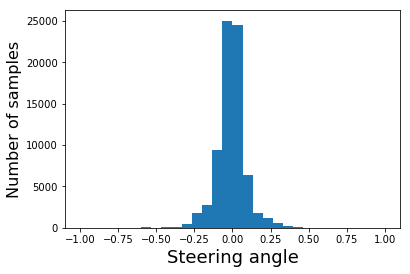

In [13]:
num_bins = 30
steering_angle = driving_log.steering_angle
steering_angle_hist, steering_angle_bins = np.histogram(steering_angle, num_bins)

def plot_stering_angle(steering_angle):
    plt.hist(steering_angle, steering_angle_bins)
    plt.xlabel('Steering angle', fontsize=18)
    plt.ylabel('Number of samples', fontsize=16)
    plt.show() 

plot_stering_angle(steering_angle)

The amount of data close to 0.0 steering angle is way too much respect all the other. I had to create a method to make sure that the data was more uniformly distributed.

Using histogram data i create a line cut for the number of samples that each bin must have, using the mean size of all bins as the maximum number of elements for each bin.


In [3]:
count_bins = [] 
for i in range(len(steering_angle_bins)-1):
    count_bins.append(len(driving_log.steering_angle[(driving_log.steering_angle > steering_angle_bins[i]) & (driving_log.steering_angle <= steering_angle_bins[i+1])  ]))

cut_line = int(np.mean(count_bins)/10)

driving_log_clean = driving_log
for i in range(len(count_bins)):
    bin_samples = driving_log[(driving_log.steering_angle > steering_angle_bins[i]) & (driving_log.steering_angle <= steering_angle_bins[i+1])  ]
    if len(bin_samples) > cut_line:
        driving_log_clean = driving_log_clean.drop(bin_samples.sample(len(bin_samples) - cut_line).index)
        

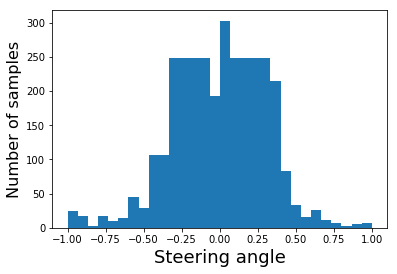

In [4]:
plot_stering_angle(driving_log_clean.steering_angle)

## Data Transformation

The idea here is to do the following transformations to the image so the neural network can work with smaller batches.

* Change color space to HSV
* Resize image to 32x64
* Crop superior and bottom part of image to remove not relevant information

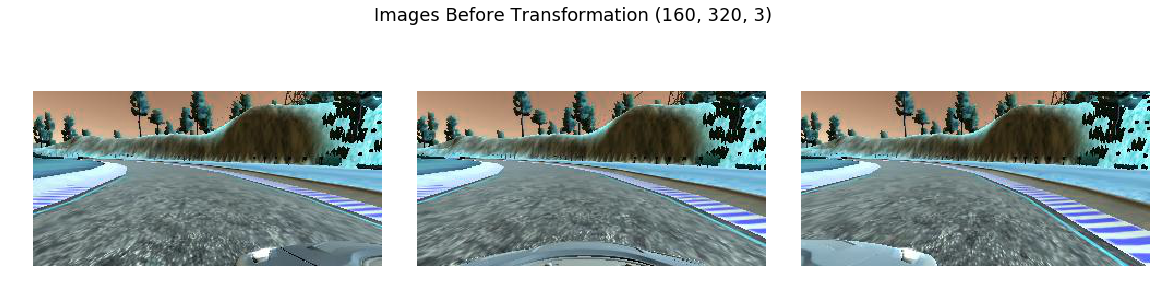

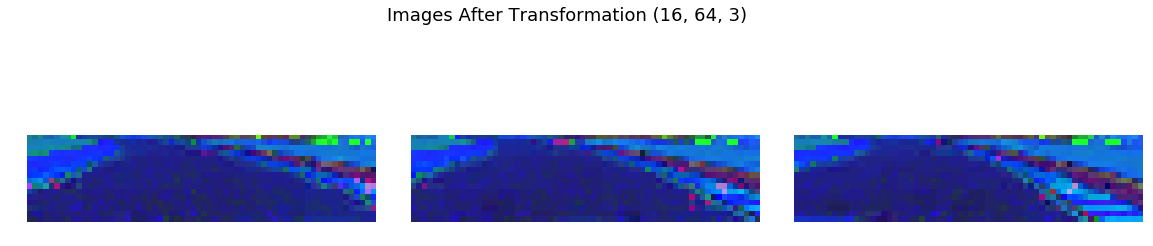

In [10]:
row = driving_log[0:1]
center_image = cv2.imread(row.center_img.values[0])
left_image = cv2.imread(row.left_img.values[0])
right_image = cv2.imread(row.right_img.values[0])

img_rows = 32
img_cols = 64

def show_img(images, title):
    gs1 = gridspec.GridSpec(1, len(images))
    plt.figure(figsize=(20,5))
    plt.suptitle(title, fontsize=18)
    gs1.update(wspace=0.1, hspace=0.5) 
    for i in range(len(images)):
        ax1 = plt.subplot(gs1[i])
        plt.imshow(images[i])
        plt.axis('off')

show_img([left_image, center_image, right_image], 'Images Before Transformation ' + str(np.shape(left_image)))

def transform_image(img):
	image = (cv2.cvtColor(img, cv2.COLOR_BGR2HSV)) # Showing the 3 channels [:, :, 1]
	image = image.reshape(160, 320, 3)
	image = cv2.resize(image, (img_cols, img_rows))[12:img_rows-4,]
	return np.reshape(image, (16, img_cols, 3))

show_img([transform_image(left_image), transform_image(center_image), transform_image(right_image)], 'Images After Transformation ' + str(np.shape(transform_image(left_image))))

